In [ ]:
from matplotlib import pyplot as plt
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchsummary
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Fall-2022/ESE-546/Project_updated"

/content/drive/MyDrive/Fall-2022/ESE-546/Project_updated


# Loading the Dataset and Target Model

Since our attack is semiwhite box we still need to train our model on the same dataset to generate new adversarial examples.

In [ ]:
use_cuda = True
image_nc = 3
batch_size = 256

# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

train_transforms = train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     
cifar10_dataset = torchvision.datasets.CIFAR10('./dataset', train=True, transform=train_transforms, download=True)
train_dataloader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

CUDA Available:  True
Files already downloaded and verified


While, we don't need the model architecture or weights for our attack, we still need to query the model multiple times. We don't have a packaged model, so we just reload the model class and weights but we only use it to query and never access the weights of the model throughout the attack.

In [ ]:
class BaseModel_All_CNN(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()

        def convbn(input, output, kernel_size, stride=1, padding=0):
            return nn.Sequential(
                nn.Conv2d(input, output, kernel_size, stride=stride, padding=padding),
                nn.ReLU(True),
                nn.BatchNorm2d(output))

        self.net = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3, c1, 3, 1, 1),
            convbn(c1, c1, 3, 1, 1),
            convbn(c1, c1, 3, 2, 1),

            nn.Dropout(0.5),
            convbn(c1, c2, 3, 1, 1),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, c2, 3, 2, 1),

            nn.Dropout(0.5),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, 10, 1, 1),

            nn.AvgPool2d(8))

        print('Num parameters: ', sum([params.numel() for params in self.net.parameters()]))

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 10)
        return x

In [ ]:
TARGET_MODEL_PATH = './CIFAR10_target_model.pth'

# Load trained base model
targeted_model = BaseModel_All_CNN().to(device)
targeted_model.load_state_dict(torch.load(TARGET_MODEL_PATH))
targeted_model.eval()

Num parameters:  1667166


BaseModel_All_CNN(
  (net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Dropout(p=0.5, inplace=False)
    (5): Sequential(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# CIFAR-10 test dataset
test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_dataset_test = torchvision.datasets.CIFAR10('./dataset', train=False, transform=test_transforms, download=True)
test_dataloader = DataLoader(cifar_dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    pred_lab = torch.argmax(targeted_model(test_img), 1)
    num_correct += torch.sum(pred_lab==test_label,0)
print('accuracy in testing set: %f\n'%(num_correct.item()/len(cifar_dataset_test)))

Files already downloaded and verified
accuracy in testing set: 0.874100



# Implementation of GANs
Discriminator and Generator implementation

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        # CIFAR-10: 3*32*32
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            # 8*32*32
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            # 16*16*16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            # 32*8*8
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            # 32*4*4
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            # 32*2*2
            nn.Conv2d(32, 1, kernel_size=2, stride=1, padding=0),
            nn.Sigmoid()
            # 1*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # CIFAR10:3*32*32
            nn.Conv2d(gen_input_nc, 8, kernel_size=5, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*28*28
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, 8, kernel_size=5, stride=1, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size, 8 x 27 x 27 
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 32 x 32
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

# Adversarial GAN attack for generating adversarial examples

In [ ]:
adv_losses = []
disc_losses = []
pert_losses = []
gen_losses = []

In [ ]:
import os
models_path = './models/'

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class AdvGAN_Attack:
    def __init__(self,
                 device,
                 model,
                 model_num_labels,
                 image_nc,
                 box_min,
                 box_max):
        output_nc = image_nc
        self.device = device
        self.model_num_labels = model_num_labels
        self.model = model
        self.input_nc = image_nc
        self.output_nc = output_nc
        self.box_min = box_min
        self.box_max = box_max

        self.gen_input_nc = image_nc
        self.netG = Generator(self.gen_input_nc, image_nc).to(device)
        self.netDisc = Discriminator(image_nc).to(device)

        # initialize all weights
        self.netG.apply(weights_init)
        self.netDisc.apply(weights_init)

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=0.001, weight_decay=1e-3)
        self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                            lr=0.001, weight_decay=1e-3)

        if not os.path.exists(models_path):
            os.makedirs(models_path)

    def train_batch(self, x, labels):
        # optimize D
        for i in range(1):
            perturbation = self.netG(x)

            # add a clipping trick
            adv_images = torch.clamp(perturbation, -0.3, 0.3) + x
            adv_images = torch.clamp(adv_images, self.box_min, self.box_max)

            self.optimizer_D.zero_grad()
            pred_real = self.netDisc(x)
            loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real, device=self.device))
            loss_D_real.backward()

            pred_fake = self.netDisc(adv_images.detach())
            loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device))
            loss_D_fake.backward()
            loss_D_GAN = loss_D_fake + loss_D_real
            self.optimizer_D.step()

        # optimize G
        for i in range(1):
            self.optimizer_G.zero_grad()

            # cal G's loss in GAN
            pred_fake = self.netDisc(adv_images)
            loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake, device=self.device))
            #loss_G_fake.backward(retain_graph=True)

            # calculate perturbation norm
            C = 1e-4
            loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))
            loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))

            # cal adv loss
            logits_model = self.model(adv_images)
            probs_model = F.softmax(logits_model, dim=1)
            onehot_labels = torch.eye(self.model_num_labels, device=self.device)[labels]

            # C&W loss function
            real = torch.sum(onehot_labels * probs_model, dim=1)
            other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
            zeros = torch.zeros_like(other)
            loss_adv = torch.max(real - other, zeros)
            loss_adv = torch.sum(loss_adv)

            # maximize cross_entropy loss
            # loss_adv = -F.mse_loss(logits_model, onehot_labels)
            # loss_adv = - F.cross_entropy(logits_model, labels)

            adv_lambda = 100
            pert_lambda = 500
            gan_lambda = 10
            loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb + gan_lambda * loss_G_fake
            loss_G.backward()
            self.optimizer_G.step()

        return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

    def train(self, train_dataloader, epochs):
        for epoch in range(1, epochs+1):

            if epoch == 50:
                #self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                #                                    lr=0.0001)
                #for op_g in self.optimizer_G.param_groups:
                #  op_g['lr'] = 0.0001
                #self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                #                                    lr=0.0001)
                for op_d in self.optimizer_D.param_groups:
                  op_d['lr'] = 0.0001
            if epoch == 80:
                #self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                #                                    lr=0.00001)
                for op_g in self.optimizer_G.param_groups:
                  op_g['lr'] = 0.00001
                #self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                #                                    lr=0.00001)
                for op_d in self.optimizer_D.param_groups:
                  op_d['lr'] = 0.00001
            loss_D_sum = 0
            loss_G_fake_sum = 0
            loss_perturb_sum = 0
            loss_adv_sum = 0
            for i, data in enumerate(train_dataloader, start=0):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)

                loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch = \
                    self.train_batch(images, labels)
                loss_D_sum += loss_D_batch
                loss_G_fake_sum += loss_G_fake_batch
                loss_perturb_sum += loss_perturb_batch
                loss_adv_sum += loss_adv_batch

            # print statistics
            num_batch = len(train_dataloader)
            disc_losses.append(loss_D_sum/num_batch)
            pert_losses.append(loss_perturb_sum/num_batch)
            adv_losses.append(loss_adv_sum/num_batch)
            gen_losses.append(loss_G_fake_sum/num_batch)
            print("epoch %d:\nloss_D: %f, loss_G_fake: %.3f,\
             \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
                  (epoch, loss_D_sum/num_batch, loss_G_fake_sum/num_batch,
                   loss_perturb_sum/num_batch, loss_adv_sum/num_batch))

            # save generator
            if epoch%20==0:
                netG_file_name = models_path + 'netG_epoch_' + str(epoch) + '.pth'
                torch.save(self.netG.state_dict(), netG_file_name)


In [ ]:
use_cuda = True
image_nc = 3
epochs = 100
batch_size = 128
BOX_MIN = 0
BOX_MAX = 1

# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model_num_labels = 10

# CIFAR-10 train dataset and dataloader declaration
cifar10_dataset = torchvision.datasets.CIFAR10('./dataset', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

adv_losses = []
disc_losses = []
pert_losses = []

advGAN = AdvGAN_Attack(device, targeted_model,
                       model_num_labels,
                       image_nc,
                       BOX_MIN,
                       BOX_MAX)

advGAN.train(dataloader, epochs)

CUDA Available:  True
Files already downloaded and verified
epoch 1:
loss_D: 0.007179, loss_G_fake: 0.964,             
loss_perturb: 5.055, loss_adv: 9.665, 

epoch 2:
loss_D: 0.000158, loss_G_fake: 0.982,             
loss_perturb: 4.619, loss_adv: 7.782, 

epoch 3:
loss_D: 0.000247, loss_G_fake: 0.978,             
loss_perturb: 4.577, loss_adv: 7.375, 

epoch 4:
loss_D: 0.000265, loss_G_fake: 0.977,             
loss_perturb: 4.568, loss_adv: 6.822, 

epoch 5:
loss_D: 0.000242, loss_G_fake: 0.978,             
loss_perturb: 4.523, loss_adv: 6.620, 

epoch 6:
loss_D: 0.000218, loss_G_fake: 0.979,             
loss_perturb: 4.466, loss_adv: 6.444, 

epoch 7:
loss_D: 0.000203, loss_G_fake: 0.980,             
loss_perturb: 4.456, loss_adv: 6.319, 

epoch 8:
loss_D: 0.000195, loss_G_fake: 0.980,             
loss_perturb: 4.353, loss_adv: 6.210, 

epoch 9:
loss_D: 0.000191, loss_G_fake: 0.981,             
loss_perturb: 4.319, loss_adv: 6.109, 

epoch 10:
loss_D: 0.000189, loss_G_fake:

# Results

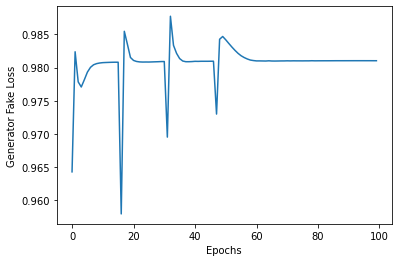

In [ ]:
plt.plot(gen_losses)
plt.ylabel("Generator Fake Loss")
plt.xlabel("Epochs")
plt.savefig("gen_losses.png")

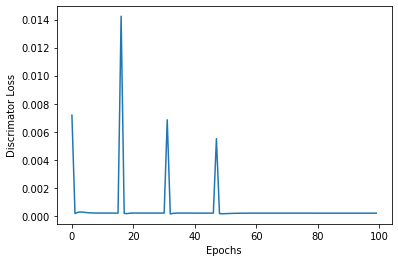

In [ ]:
plt.plot(disc_losses)
plt.ylabel("Discrimator Loss")
plt.xlabel("Epochs")
plt.savefig("disc_losses.png")

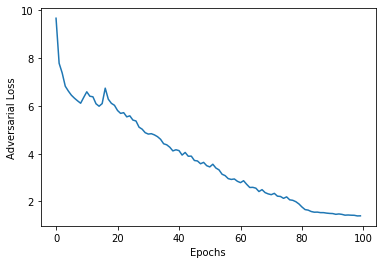

In [ ]:
plt.plot(adv_losses)
plt.ylabel("Adversarial Loss")
plt.xlabel("Epochs")
plt.savefig("adv_losses.png")

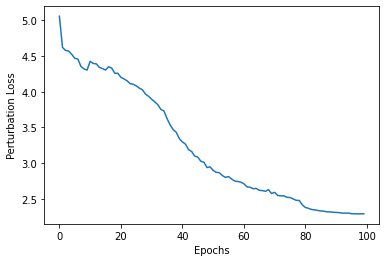

In [ ]:
plt.plot(pert_losses)
plt.ylabel("Perturbation Loss")
plt.xlabel("Epochs")
plt.savefig("pert_losses.png")

In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#import models
#from models import MNIST_target_net

use_cuda=True
image_nc=3
batch_size = 128

gen_input_nc = image_nc

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# load the pretrained model
pretrained_model = "./CIFAR10_target_model.pth"
target_model = BaseModel_All_CNN().to(device)
target_model.load_state_dict(torch.load(pretrained_model))
target_model.eval()

# load the generator of adversarial examples
pretrained_generator_path = './models/netG_epoch_100.pth'
pretrained_G = Generator(gen_input_nc, image_nc).to(device)
pretrained_G.load_state_dict(torch.load(pretrained_generator_path))
#pretrained_G.eval()

# test adversarial examples in CIFAR-10 training dataset
cifar_train = torchvision.datasets.CIFAR10('./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(train_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('CIFAR-10 training dataset:')
print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in training set: %f\n'%(num_correct.item()/len(cifar_train)))

# test adversarial examples in CIFAR-10 testing dataset
cifar_test = torchvision.datasets.CIFAR10('./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)


print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in testing set: %f\n'%(num_correct.item()/len(cifar_test)))


CUDA Available:  True
Num parameters:  1667166
Files already downloaded and verified
CIFAR-10 training dataset:
num_correct:  2456
accuracy of adv imgs in training set: 0.049120

Files already downloaded and verified
num_correct:  1307
accuracy of adv imgs in testing set: 0.130700



In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

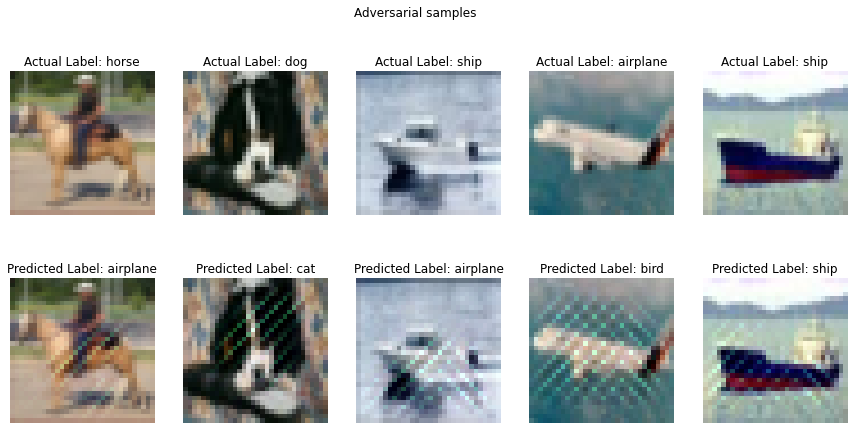

In [ ]:

fig = plt.figure(figsize=(15, 7))

for i in range(5):
  im = transforms.ToPILImage()(test_img[i, :, :, :]).convert("RGB")
  im.save('Images/adv_example' + str(i) + '.png')

  im1 = transforms.ToPILImage()(adv_img[i, :, :, :]).convert("RGB")
  im1.save('Images/test_image' + str(i) + '.png')

  ax = fig.add_subplot(2, 5, i+1)
  ax.title.set_text('Actual Label: {}'.format(classes[test_label[i]]))
  ax.imshow(im)
  plt.axis('off')

  ax = fig.add_subplot(2, 5, i+6)
  ax.title.set_text('Predicted Label: {}'.format(classes[pred_lab[i]]))
  ax.imshow(im1)
  plt.axis('off')

plt.suptitle('Adversarial samples')
plt.show();